In [1]:
%pylab inline 
#This is an ipython magic to import numpy and matplotlib (to produce graphs)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.io.fits as fits #This library handles FITS files (There are other libraries to do so in python as well)
from skimage.morphology import disk
from skimage.filters import rank
from astropy.visualization import make_lupton_rgb
from reproject import reproject_interp, reproject_exact
from photutils import CircularAperture
from photutils import aperture_photometry

Let's take a look at the original images that you took

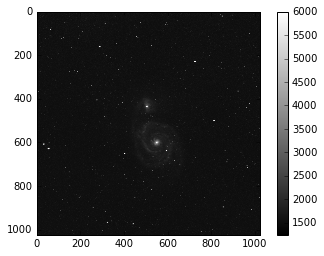

In [31]:
science_image_path_g = '/Users/javiers/McQ_data/m51_g-band_120sec_bin2_2016feb16_drew_num3_seo.fits' #Type the path to your image
sci_im_g = fits.open(science_image_path_g)[0].data
plt.imshow(sci_im_g,cmap='gray',vmax=6000)
plt.colorbar()

This image is not science-ready yet...

Dark image: If you take a shot with the shutter closed (i.e., no light/photons incoming in the camera) you still have a non-zero image.

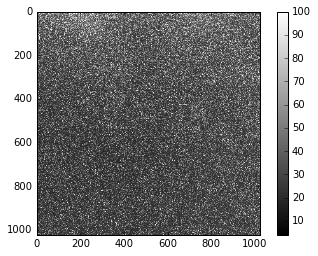

In [4]:
dark_image_path='/Users/javiers/McQ_data/DARK.fits'
drk_im = fits.open(dark_image_path)[0].data
plt.imshow(drk_im,cmap='gray',vmax=100)
plt.colorbar()

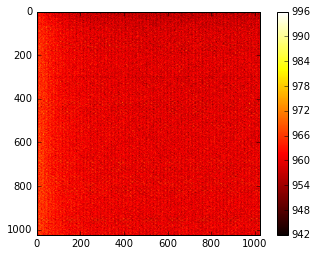

In [22]:
bias_image_path = '/Users/javiers/McQ_data/BIAS.fits'
bias_image = fits.open(bias_image_path)[0].data
plt.imshow(bias_image, cmap='hot')
plt.colorbar()

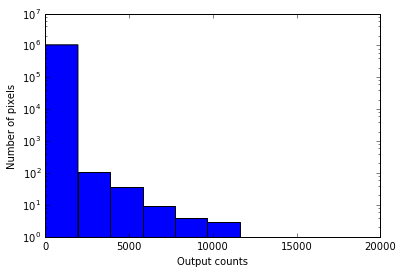

In [5]:
plt.hist(drk_im.flatten());
plt.yscale('log')
plt.xlabel('Output counts')
plt.ylabel('Number of pixels')

Why is this?

Another interesting feature of CCD cameras is that the chips do not respond equally to the same light intensity. For example if you illuminate the camera with uniform light (this is called *flat* image). 

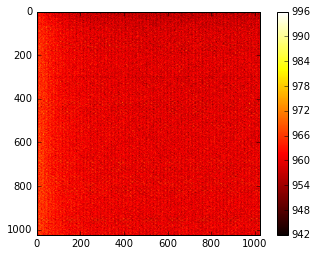

In [6]:
flat_image_path = '/Users/javiers/McQ_data/FLAT.fits'
flat_image = fits.open(flat_image_path)[0].data
plt.imshow(flat_image, cmap='hot')
plt.colorbar()

In [23]:
def reduce_image(sci_im,drk_im,flat_im, bias_im, filter_dark=True):
    selem = disk(4) #We are going to perform averages in 4 pixel radius disks
    dkr_im = drk_im - bias_im
    #First part: We take "zero" the image
    if(filter_dark):
        drk_im = rank.mean(drk_im, selem=selem) #We perform an average to remove salt-pepper noise
    #Second part: Make that every part has the same sensitivity
    flat_im = flat_im/np.median(flat_im) #it will be 1 in the pixels that are in the median
    #Lower than 1 where the CCD is less sensitive and more than 1 where it's more sensitive
    sci_im = (sci_im -drk_im)/flat_im
    #Error image
    return sci_im

Let's create a better image!

In [24]:
new_sci_image_g = reduce_image(sci_im_g,drk_im,flat_image,bias_image)

Compare to the original!

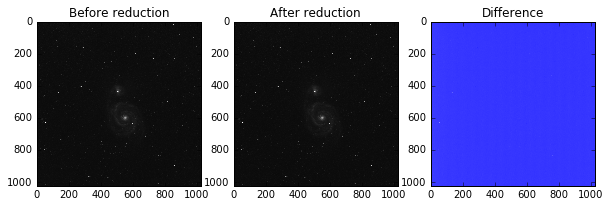

In [9]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(10,8))
ax[0].imshow(sci_im_g,cmap='gray',vmax=7000)
ax[0].set_title('Before reduction')
ax[1].imshow(new_sci_image_g,cmap='gray',vmax=7000)
ax[1].set_title('After reduction')
ax[2].imshow(sci_im_g-new_sci_image_g,cmap='bwr')
ax[2].set_title('Difference')

In [10]:
science_image_path_r = '/Users/javiers/McQ_data/m51_r-band_120sec_bin2_2016feb16_drew_num4_seo.fits' 
sci_im_r = fits.open(science_image_path_r)[0].data
science_image_path_i = '/Users/javiers/McQ_data/m51_i-band_120sec_bin2_2016feb16_drew_num5_seo.fits'
sci_im_i = fits.open(science_image_path_i)[0].data

Reduce the rest of images (in principle we should take a different bias image for each filter) because the CCD has different sensitivity at different wavelengths

In [25]:
new_sci_image_r = reduce_image(sci_im_r,drk_im,flat_image,bias_image)
new_sci_image_i = reduce_image(sci_im_i,drk_im,flat_image,bias_image)

In [26]:
sci_r = fits.open(science_image_path_r)
sci_r[0].data = new_sci_image_r
sci_i = fits.open(science_image_path_i)
sci_i[0].data = new_sci_image_i

In [27]:
# remap r and i onto g
r_new, r_mask = reproject_interp(sci_r, fits.open(science_image_path_g)[0].header)
i_new, i_mask = reproject_interp(sci_i, fits.open(science_image_path_g)[0].header)

# zero out the unmapped values
i_new[np.logical_not(i_mask)] = 0
r_new[np.logical_not(r_mask)] = 0

In [28]:
sci_r[0].data = r_new
sci_i[0].data = i_new

Let's check the color images!

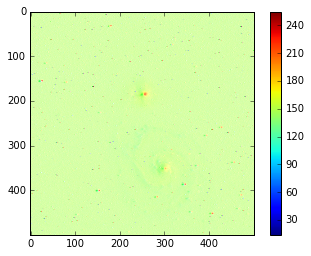

In [29]:
image = make_lupton_rgb(i_new, r_new, new_sci_image_g,stretch=0.5,filename='/Users/javiers/McQ_data/m51.jpg')
plt.imshow(image[250:750,250:750])
plt.colorbar()

An example from SDSS:

In [18]:
# Read in the three images downloaded from here:
# g: http://dr13.sdss.org/sas/dr13/eboss/photoObj/frames/301/1737/5/frame-g-001737-5-0039.fits.bz2
# r: http://dr13.sdss.org/sas/dr13/eboss/photoObj/frames/301/1737/5/frame-r-001737-5-0039.fits.bz2
# i: http://dr13.sdss.org/sas/dr13/eboss/photoObj/frames/301/1737/5/frame-i-001737-5-0039.fits.bz2
g = fits.open('/Users/javiers/McQ_data/frame-g-001737-5-0039.fits.bz2')[0]
r = fits.open('/Users/javiers/McQ_data/frame-r-001737-5-0039.fits.bz2')[0]
i = fits.open('/Users/javiers/McQ_data/frame-i-001737-5-0039.fits.bz2')[0]

# remap r and i onto g
r_new, r_mask = reproject_interp(r, g.header)
i_new, i_mask = reproject_interp(i, g.header)

# zero out the unmapped values
i_new[np.logical_not(i_mask)] = 0
r_new[np.logical_not(r_mask)] = 0

# red=i, green=r, blue=g
# make a file with the default scaling
rgb_default = make_lupton_rgb(i_new, r_new, g.data, filename="ngc6976-default.jpeg")
# this scaling is very similar to the one used in Lupton et al. (2004)
rgb = make_lupton_rgb(i_new, r_new, g.data, Q=10, stretch=0.5, filename="ngc6976.jpeg")


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


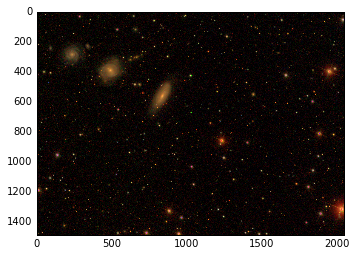

In [19]:
plt.imshow(rgb)

If you want to know more about Jupyter:
https://github.com/fjaviersanchez/JupyterTutorial/blob/master/TutorialJupyter.ipynb

## Aperture photometry

Astronomers use the magnitude scale to characterize the bright of an object. With the magnitude scale you quantify the brightness of an object by comparing it with other objects. Astronomers have agreed to use "Vega" as the zero magnitude point (like the freezing point for water is the zero-point for the Celsius temperature scale). The magnitude scale goes "backwards" in the sense that brighter objects have smaller magnitude. For example the Sun has magnitude -27, the full Moon -13, and Venus -5. 

How can we measure magnitudes from an image?

A first approach is to use an object which magnitude we know, called "standard" and refer the rest of the objects in an image to it.

But what do you use to count the total brightness of an object?

* Use the brightest pixel?
* Add the brightness in a certain radius?
* Count only the pixels which belong to each object?

In [20]:
positions = [(550., 600.), (450., 500.)] #Change it and include the position of an object in your image
apertures = CircularAperture(positions, r=20.)
phot_table = aperture_photometry(new_sci_image_g, apertures)

In [21]:
print phot_table

 aperture_sum xcenter ycenter
                pix     pix  
------------- ------- -------
3455475.00625   550.0   600.0
2066203.77093   450.0   500.0


Astronomers use both disks and complicated shapes to measure the brightness and they then refer to a known object!